# Stock Price Prediction Using RNNs

## Objective
The objective of this assignment is to try and predict the stock prices using historical data from four companies IBM (IBM), Google (GOOGL), Amazon (AMZN), and Microsoft (MSFT).

We use four different companies because they belong to the same sector: Technology. Using data from all four companies may improve the performance of the model. This way, we can capture the broader market sentiment.

The problem statement for this assignment can be summarised as follows:

> Given the stock prices of Amazon, Google, IBM, and Microsoft for a set number of days, predict the stock price of these companies after that window.

## Business Value

Data related to stock markets lends itself well to modeling using RNNs due to its sequential nature. We can keep track of opening prices, closing prices, highest prices, and so on for a long period of time as these values are generated every working day. The patterns observed in this data can then be used to predict the future direction in which stock prices are expected to move. Analyzing this data can be interesting in itself, but it also has a financial incentive as accurate predictions can lead to massive profits.

### **Data Description**

You have been provided with four CSV files corresponding to four stocks: AMZN, GOOGL, IBM, and MSFT. The files contain historical data that were gathered from the websites of the stock markets where these companies are listed: NYSE and NASDAQ. The columns in all four files are identical. Let's take a look at them:

- `Date`: The values in this column specify the date on which the values were recorded. In all four files, the dates range from Jaunary 1, 2006 to January 1, 2018.

- `Open`: The values in this column specify the stock price on a given date when the stock market opens.

- `High`: The values in this column specify the highest stock price achieved by a stock on a given date.

- `Low`: The values in this column specify the lowest stock price achieved by a stock on a given date.

- `Close`: The values in this column specify the stock price on a given date when the stock market closes.

- `Volume`: The values in this column specify the total number of shares traded on a given date.

- `Name`: This column gives the official name of the stock as used in the stock market.

There are 3019 records in each data set. The file names are of the format `\<company_name>_stock_data.csv`.

## **1 Data Loading and Preparation** <font color =red> [25 marks] </font>

#### **Import Necessary Libraries**

In [9]:
# Import libraries
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,Callback,LearningRateScheduler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score 
from keras.layers import Dense, Dropout, MaxPooling2D, BatchNormalization, SimpleRNN, LSTM, GRU,Bidirectional
from keras.optimizers import Adam
import itertools

### **1.1 Data Aggregation** <font color =red> [7 marks] </font>

As we are using the stock data for four different companies, we need to create a new DataFrame that contains the combined data from all four data frames. We will create a function that takes in a list of the file names for the four CSV files, and returns a single data frame. This function performs the following tasks:
- Extract stock names from file names
- Read the CSV files as data frames
- Append the stock names into the columns of their respective data frames
- Drop unnecessary columns
- Join the data frames into one.

#### **1.1.1** <font color =red> [5 marks] </font>
Create the function to join DataFrames and use it to combine the four datasets.

In [13]:
# Define a function to load data and aggregate them
def merged_data(list):
    merged_df=None
    for path in list:
        stock_name=path.split('/')[-1].split('_')[0]
        df=pd.read_csv(path)
        df = df.drop(columns=['Name'])
        df=df.rename(columns=lambda col: col if col == 'Date' else f"{stock_name}_{col}" )
        if merged_df is None:
            merged_df=df
        else:
            merged_df=pd.merge(merged_df,df, on='Date', how='inner')
    return merged_df

In [14]:
# Specify the names of the raw data files to be read and use the aggregation function to read the files
list=["RNN_Stocks_Data/AMZN_stocks_data.csv",
      "RNN_Stocks_Data/GOOGL_stocks_data.csv",
      "RNN_Stocks_Data/IBM_stocks_data.csv",
      "RNN_Stocks_Data/MSFT_stocks_data.csv"]


In [20]:
# View specifics of the data
merged_df=merged_data(list)
merged_df.head()

Date  AMZN_Open  AMZN_High  AMZN_Low  AMZN_Close  AMZN_Volume  \
0  2006-01-03      47.47      47.85     46.25       47.58      7582127   
1  2006-01-04      47.48      47.73     46.69       47.25      7440914   
2  2006-01-05      47.16      48.20     47.11       47.65      5417258   
3  2006-01-06      47.97      48.58     47.32       47.87      6154285   
4  2006-01-09      46.55      47.10     46.40       47.08      8945056   

   GOOGL_Open  GOOGL_High  GOOGL_Low  GOOGL_Close  ...  IBM_Open  IBM_High  \
0      211.47      218.05     209.32       217.83  ...     82.45     82.55   
1      222.17      224.70     220.09       222.84  ...     82.20     82.50   
2      223.22      226.00     220.97       225.85  ...     81.40     82.90   
3      228.66      235.49     226.85       233.06  ...     83.95     85.03   
4      233.44      236.94     230.70       233.68  ...     84.10     84.25   

   IBM_Low  IBM_Close  IBM_Volume  MSFT_Open  MSFT_High  MSFT_Low  MSFT_Close  \
0    80.81      82.06    11715200      26.25      27.00     26.10       26.84   
1    81.33      81.95     9840600      26.77      27.08     26.77       26.97   
2    81.00      82.50     7213500      26.96      27.13     26.91       26.99   
3    83.41      84.95     8197400      26.89      27.00     26.49       26.91   
4    83.38      83.73     6858200      26.93      27.07     26.76       26.86   

   MSFT_Volume  
0     79974418  
1     57975661  
2     48247610  
3    100969092  
4     55627836  

[5 rows x 21 columns]

In [22]:
merged_df.shape

(3019, 21)

In [24]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3019 entries, 0 to 3018
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          3019 non-null   object 
 1   AMZN_Open     3019 non-null   float64
 2   AMZN_High     3019 non-null   float64
 3   AMZN_Low      3019 non-null   float64
 4   AMZN_Close    3019 non-null   float64
 5   AMZN_Volume   3019 non-null   int64  
 6   GOOGL_Open    3019 non-null   float64
 7   GOOGL_High    3019 non-null   float64
 8   GOOGL_Low     3019 non-null   float64
 9   GOOGL_Close   3019 non-null   float64
 10  GOOGL_Volume  3019 non-null   int64  
 11  IBM_Open      3018 non-null   float64
 12  IBM_High      3019 non-null   float64
 13  IBM_Low       3018 non-null   float64
 14  IBM_Close     3019 non-null   float64
 15  IBM_Volume    3019 non-null   int64  
 16  MSFT_Open     3019 non-null   float64
 17  MSFT_High     3019 non-null   float64
 18  MSFT_Low      3019 non-null 

In [26]:
#converting date column to datetime index:
merged_df['Date']=pd.to_datetime(merged_df['Date'])
print(merged_df.Date.dtype)

datetime64[ns]


In [28]:
#extracting ['Year','Month','Day','Quarter','Week'] just to estimate what window should be used we will delete theese along with Date column later on
merged_df['Year'] = merged_df['Date'].dt.year
merged_df['Month']=pd.DatetimeIndex(merged_df['Date']).month
merged_df['Day']=pd.DatetimeIndex(merged_df.Date).day
merged_df['Quarter']=pd.DatetimeIndex(merged_df.Date).quarter
merged_df['Week']=merged_df['Date'].dt.isocalendar().week

- extracted 'Year','Month','Day','Quarter','Week' columns from Date column for EDA.

In [31]:
merged_df.tail(20)

Date  AMZN_Open  AMZN_High  AMZN_Low  AMZN_Close  AMZN_Volume  \
2999 2017-12-01    1172.05    1179.65   1152.00     1162.35      4107094   
3000 2017-12-04    1173.85    1175.20   1128.00     1133.95      5931915   
3001 2017-12-05    1128.26    1159.27   1124.74     1141.57      4079774   
3002 2017-12-06    1137.99    1155.89   1136.08     1152.35      2853316   
3003 2017-12-07    1156.59    1163.19   1151.00     1159.79      2511569   
3004 2017-12-08    1170.40    1172.79   1157.10     1162.00      3050074   
3005 2017-12-11    1164.60    1169.90   1157.00     1168.92      2363473   
3006 2017-12-12    1166.51    1173.60   1161.61     1165.08      2235892   
3007 2017-12-13    1170.00    1170.87   1160.27     1164.13      2616760   
3008 2017-12-14    1163.71    1177.93   1162.45     1174.26      3214337   
3009 2017-12-15    1179.03    1182.75   1169.33     1179.14      4778621   
3010 2017-12-18    1187.37    1194.78   1180.91     1190.58      2947625   
3011 2017-12-19    1189.15    1192.97   1179.14     1187.38      2587792   
3012 2017-12-20    1190.50    1191.00   1176.00     1177.62      2371166   
3013 2017-12-21    1175.90    1179.17   1167.64     1174.76      2123117   
3014 2017-12-22    1172.08    1174.62   1167.83     1168.36      1585054   
3015 2017-12-26    1168.36    1178.32   1160.55     1176.76      2005187   
3016 2017-12-27    1179.91    1187.29   1175.61     1182.26      1867208   
3017 2017-12-28    1189.00    1190.10   1184.38     1186.10      1841676   
3018 2017-12-29    1182.35    1184.00   1167.50     1169.47      2688391   

      GOOGL_Open  GOOGL_High  GOOGL_Low  GOOGL_Close  ...  MSFT_Open  \
2999     1030.41     1037.24    1016.90      1025.07  ...      83.60   
3000     1027.80     1031.34    1009.22      1011.87  ...      84.42   
3001     1010.99     1036.68    1002.32      1019.60  ...      81.34   
3002     1016.52     1039.58    1015.31      1032.72  ...      81.55   
3003     1036.07     1048.92    1035.36      1044.57  ...      82.54   
3004     1051.81     1056.42    1045.86      1049.38  ...      83.63   
3005     1051.11     1056.00    1044.12      1051.97  ...      84.29   
3006     1050.00     1062.50    1044.87      1048.77  ...      85.31   
3007     1052.08     1055.48    1046.58      1051.39  ...      85.74   
3008     1055.49     1067.08    1053.60      1057.47  ...      85.43   
3009     1063.78     1075.25    1060.09      1072.00  ...      85.26   
3010     1076.45     1086.49    1070.37      1085.09  ...      87.12   
3011     1083.02     1084.98    1072.27      1079.78  ...      86.35   
3012     1080.92     1081.24    1068.60      1073.56  ...      86.20   
3013     1075.39     1077.52    1069.00      1070.85  ...      86.05   
3014     1070.00     1071.72    1067.64      1068.86  ...      85.40   
3015     1068.64     1068.86    1058.64      1065.85  ...      85.31   
3016     1066.60     1068.27    1058.38      1060.20  ...      85.65   
3017     1062.25     1064.84    1053.38      1055.95  ...      85.90   
3018     1055.49     1058.05    1052.70      1053.40  ...      85.63   

      MSFT_High  MSFT_Low  MSFT_Close  MSFT_Volume  Year  Month  Day  Quarter  \
2999      84.81     83.22       84.26     29532132  2017     12    1        4   
3000      84.43     80.70       81.08     39094880  2017     12    4        4   
3001      82.68     80.98       81.59     26152261  2017     12    5        4   
3002      83.14     81.43       82.78     26162054  2017     12    6        4   
3003      82.80     82.00       82.49     23184547  2017     12    7        4   
3004      84.58     83.33       84.16     24489106  2017     12    8        4   
3005      85.37     84.12       85.23     22857854  2017     12   11        4   
3006      86.05     85.08       85.58     23924105  2017     12   12        4   
3007      86.00     85.17       85.35     22062679  2017     12   13        4   
3008      85.87     84.53       84.69     19305961  2017     12   14        4   
3009      

#### **1.1.2** <font color =red> [2 marks] </font>
Identify and handle any missing values.

In [34]:
# Handle Missing Values
merged_df.isna().sum()

Date            0
AMZN_Open       0
AMZN_High       0
AMZN_Low        0
AMZN_Close      0
AMZN_Volume     0
GOOGL_Open      0
GOOGL_High      0
GOOGL_Low       0
GOOGL_Close     0
GOOGL_Volume    0
IBM_Open        1
IBM_High        0
IBM_Low         1
IBM_Close       0
IBM_Volume      0
MSFT_Open       0
MSFT_High       0
MSFT_Low        0
MSFT_Close      0
MSFT_Volume     0
Year            0
Month           0
Day             0
Quarter         0
Week            0
dtype: int64

- There are 2 missing values

In [37]:
merged_df=merged_df.dropna()

In [39]:
print(merged_df.isna().sum())
print(merged_df.shape)

Date            0
AMZN_Open       0
AMZN_High       0
AMZN_Low        0
AMZN_Close      0
AMZN_Volume     0
GOOGL_Open      0
GOOGL_High      0
GOOGL_Low       0
GOOGL_Close     0
GOOGL_Volume    0
IBM_Open        0
IBM_High        0
IBM_Low         0
IBM_Close       0
IBM_Volume      0
MSFT_Open       0
MSFT_High       0
MSFT_Low        0
MSFT_Close      0
MSFT_Volume     0
Year            0
Month           0
Day             0
Quarter         0
Week            0
dtype: int64
(3018, 26)


### **1.2 Analysis and Visualisation** <font color =red> [5 marks] </font>

#### **1.2.1** <font color =red> [2 marks] </font>
Analyse the frequency distribution of stock volumes of the companies and also see how the volumes vary over time.

In [43]:
#Defining List of stocks
stocks1 = ['AMZN', 'GOOGL', 'IBM', 'MSFT']

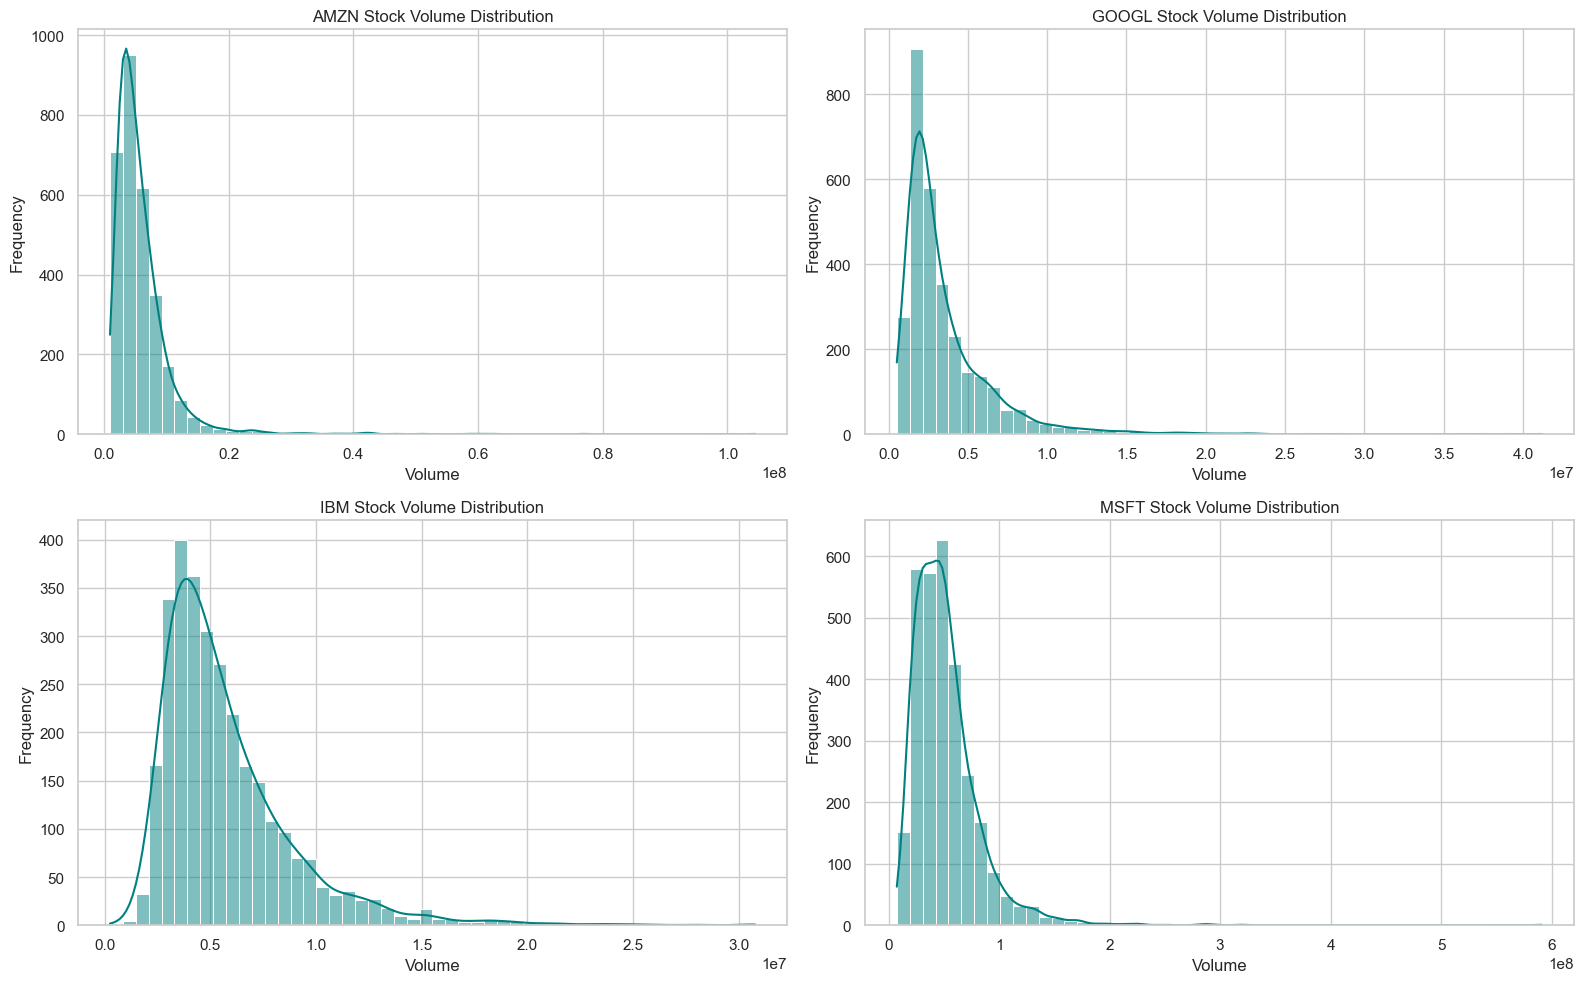

In [45]:
# Frequency distribution of volumes
sns.set(style="whitegrid")
plt.figure(figsize=(16, 10))

for i, stock in enumerate(stocks1):
    plt.subplot(2, 2, i + 1)
    sns.histplot(merged_df[f'{stock}_Volume'], bins=50, kde=True, color='teal')
    plt.title(f'{stock} Stock Volume Distribution')
    plt.xlabel('Volume')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()



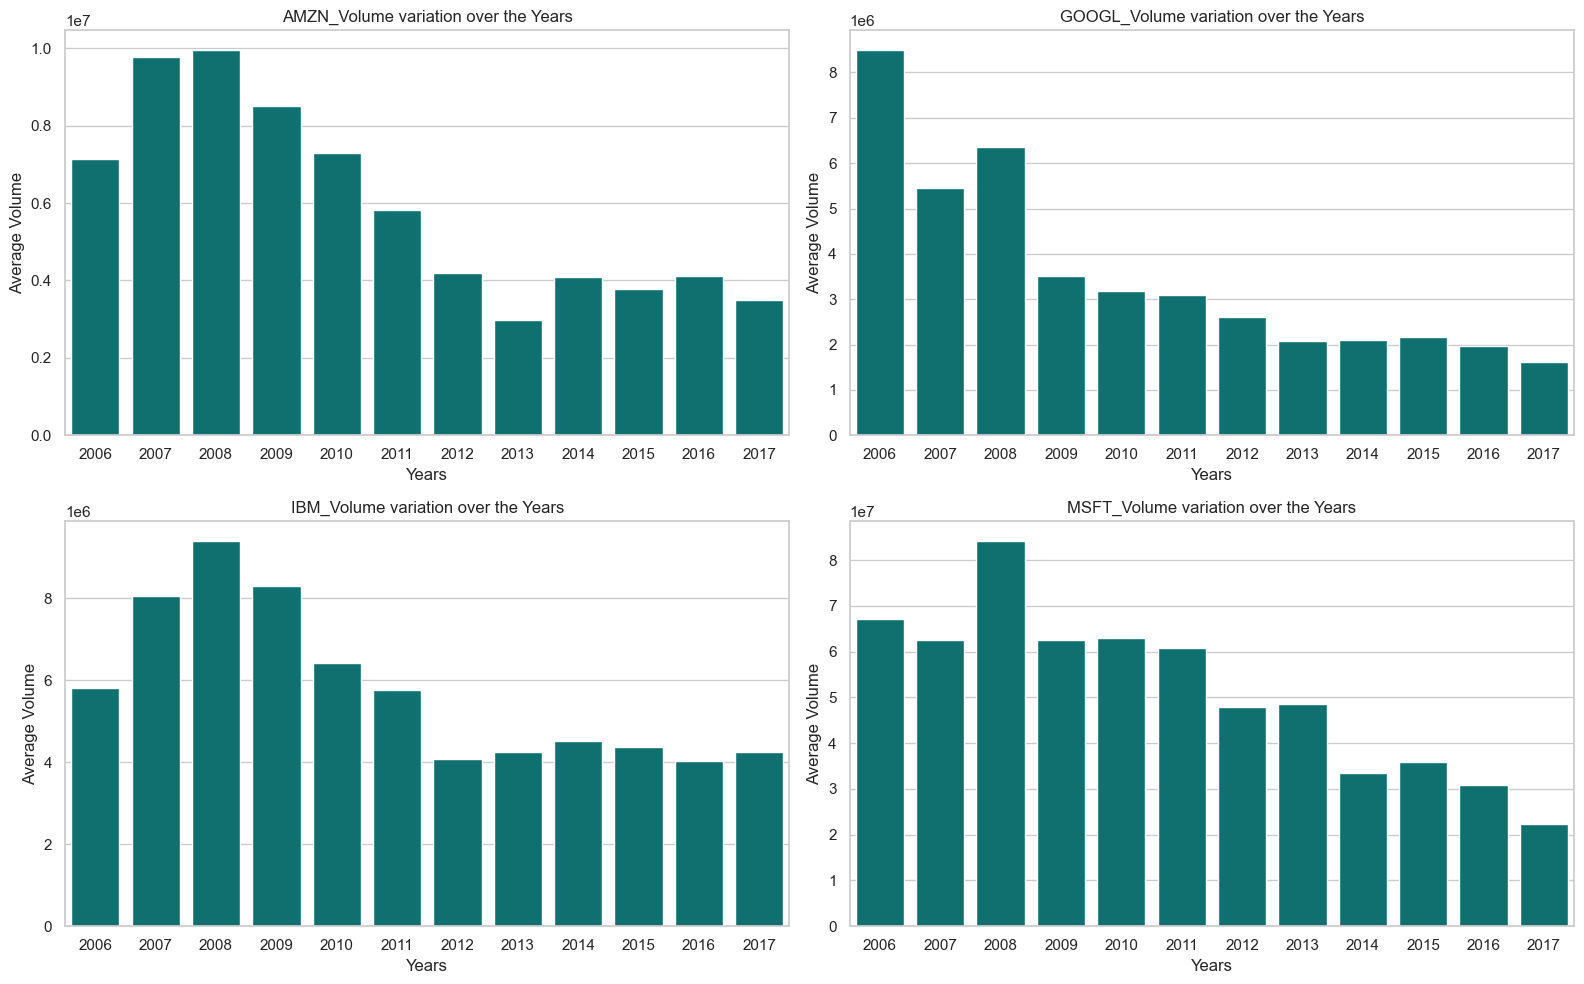

In [47]:
# Stock volume variation over time
plt.figure(figsize=(16,10))
for i, stock in enumerate(stocks1):
    plt.subplot(2,2,i+1)
    mean_vol=merged_df.groupby('Year')[f"{stock}_Volume"].mean().reset_index()
    sns.barplot(x='Year', y=f"{stock}_Volume", data=mean_vol, color='teal')
    plt.title(f"{stock}_Volume variation over the Years")
    plt.xlabel("Years")
    plt.ylabel("Average Volume")
plt.tight_layout()
plt.show()

- Stock Volume has decreased over the years. that's ussually a indicator of rise in the stock price.
- Google's volume has significantly decreased over the years
- IBM stock volume is stable after 2012

#### **1.2.2** <font color =red> [3 marks] </font>
Analyse correlations between features.

In [51]:
# Analyse correlations
corr_df=merged_df.copy()

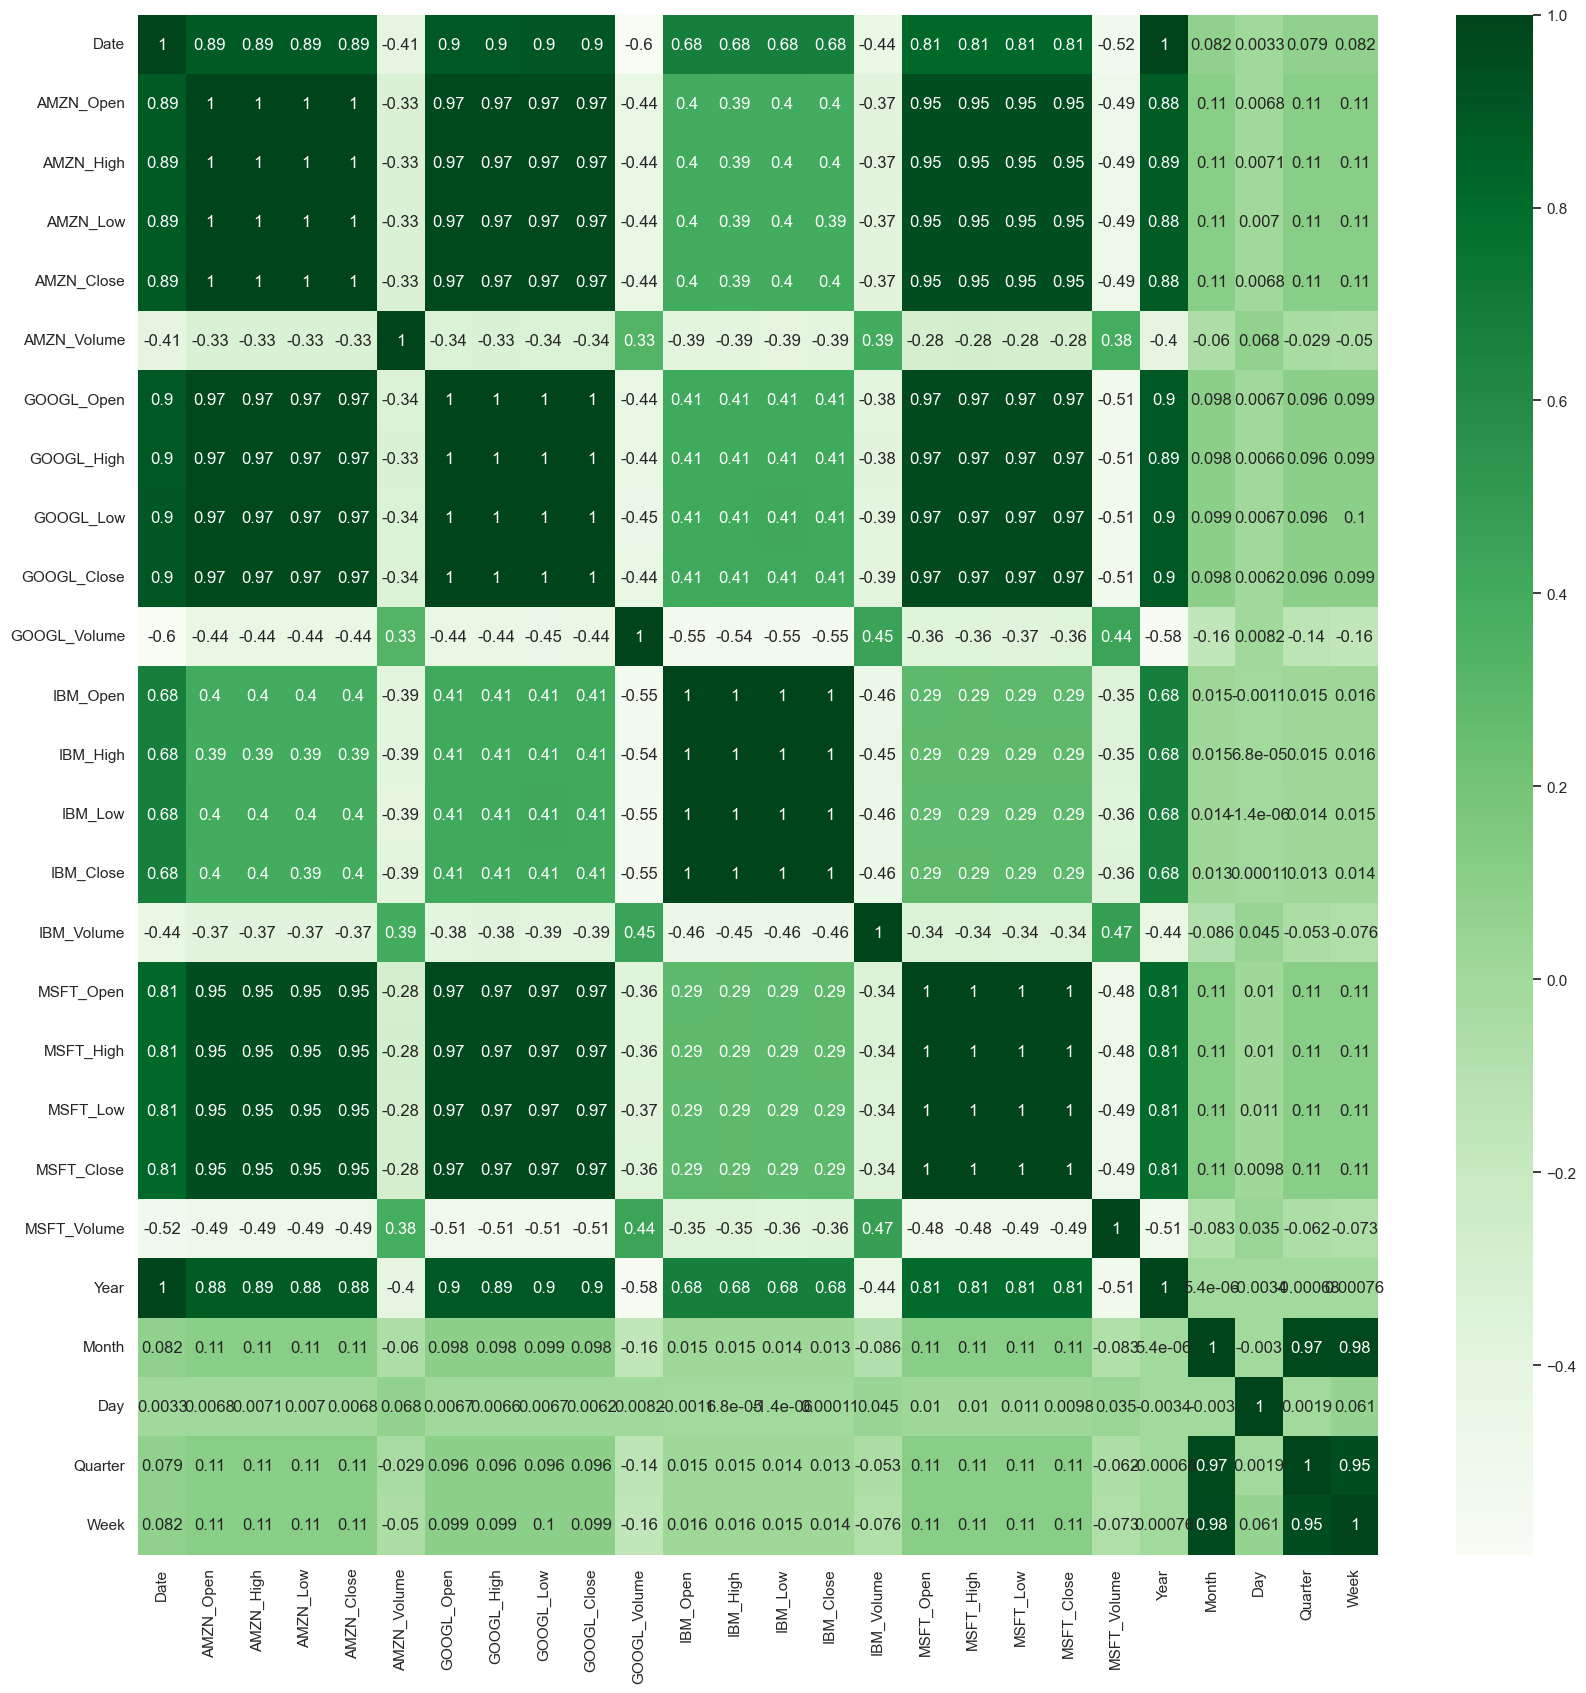

In [53]:
#plotting the heatmap
merged_df_corr=corr_df.corr()
plt.figure(figsize=(20,20))
sns.heatmap(merged_df_corr,annot=True,cmap='Greens')
plt.show()

### **1.3 Data Processing** <font color =red> [13 marks] </font>

Next, we need to process the data so that it is ready to be used in recurrent neural networks. You know RNNs are suitable to work with sequential data where patterns repeat at regular intervals.

For this, we need to execute the following steps:
1. Create windows from the master data frame and obtain windowed `X` and corresponding windowed `y` values
2. Perform train-test split on the windowed data
3. Scale the data sets in an appropriate manner

We will define functions for the above steps that finally return training and testing data sets that are ready to be used in recurrent neural networks.

**Hint:** If we use a window of size 3, in the first window, the rows `[0, 1, 2]` will be present and will be used to predict the value of `CloseAMZN` in row `3`. In the second window, rows `[1, 2, 3]` will be used to predict `CloseAMZN` in row `4`.

#### **1.3.1** <font color =red> [3 marks] </font>
Create a function that returns the windowed `X` and `y` data.

From the main DataFrame, this function will create windowed DataFrames, and store those as a list of DataFrames.

Controllable parameters will be window size, step size (window stride length) and target names as a list of the names of stocks whose closing values we wish to predict.

In [60]:
# Define a function that divides the data into windows and generates target variable values for each window
def windows(df, target, window_size, stride):
    X,y=[],[]
    num_features=df.shape[1]
    data=df.values
    target_index=[df.columns.get_loc(col) for col in target]

    for start in range(0, len(data)-window_size,stride):
        end=start+window_size
        if end >=len(data):
            break
        window=data[start:end]
        target_val=data[end][target_index]

        X.append(window)
        y.append(target_val)
    return np.array(X), np.array(y)
    


#### **1.3.2** <font color =red> [3 marks] </font>
Create a function to scale the data.

Define a function that will scale the data.

For scaling, we have to look at the whole length of data to find max/min values or standard deviations and means. If we scale the whole data at once, this will lead to data leakage in the windows. This is not necessarily a problem if the model is trained on the complete data with cross-validation.

One way to scale when dealing with windowed data is to use the `partial_fit()` method.
```
scaler.partial_fit(window)
scaler.transform(window)
```
You may use any other suitable way to scale the data properly. Arrive at a reasonable way to scale your data.

In [64]:
# Define a function that scales the windowed data

# The function takes in the windowed data sets and returns the scaled windows

def scaled(X,y):
    X_scaler=MinMaxScaler()
    X_scaled=[]
    y_scaler=MinMaxScaler()
    y_scaled=[]
    for window in X:
        X_scaler.partial_fit(window)
        scaled_window=X_scaler.transform(window)
        X_scaled.append(scaled_window)
    X_scaled=np.array(X_scaled)
    y_scaled=y_scaler.fit_transform(y)
    return X_scaled,y_scaled,X_scaler,y_scaler


- We are returning scalers to remove the normalization on the dataset for evaluating the model

Next, define the main function that will call the windowing and scaling helper functions.

The input parameters for this function are:
- The joined master data set
- The names of the stocks that we wish to predict the *Close* prices for
- The window size
- The window stride
- The train-test split ratio

The outputs from this function are the scaled dataframes:
- *X_train*
- *y_train*
- *X_test*
- *y_test*

#### **1.3.3** <font color =red> [3 marks] </font>
Define a function to create windows of `window_size` and split the windowed data in to training and validation sets.

The function can take arguments such as list of target names, window size, window stride and split ratio. Use the windowing function here to make windows in the data and then perform scaling and train-test split.

In [70]:
# Define a function to create input and output data points from the master DataFrame
def master(df1,target_master,window_size_master,stride_master,split):
    X,y=windows(df1, target_master,window_size_master,stride_master)
    X,y,X_scaler,y_scaler=scaled(X,y)
    split_index=int(len(X)*split)
    X_train=X[:split_index]
    X_test=X[split_index:]
    y_train=y[:split_index]
    y_test=y[split_index:]
    return X_train,y_train,X_test,y_test,X_scaler,y_scaler
    

- We are returning scalers to remove the normalization on the dataset for evaluating the model

We can now use these helper functions to create our training and testing data sets. But first we need to decide on a length of windows. As we are doing time series prediction, we want to pick a sequence that shows some repetition of patterns.

For selecting a good sequence length, some business understanding will help us. In financial scenarios, we can either work with business days, weeks (which comprise of 5 working days), months, or quarters (comprising of 13 business weeks). Try looking for some patterns for these periods.

#### **1.3.4** <font color =red> [2 marks] </font>
Identify an appropriate window size.

For this, you can use plots to see how target variable is varying with time. Try dividing it into parts by weeks/months/quarters.

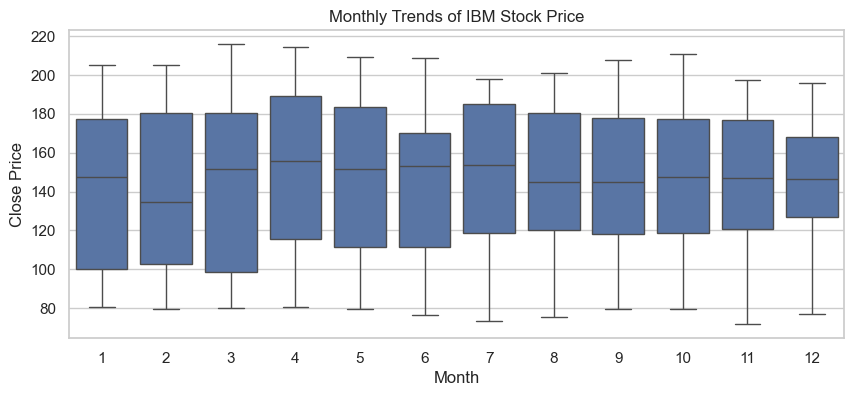

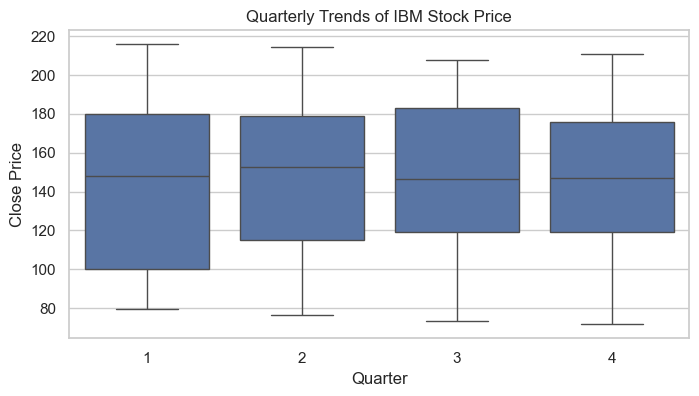

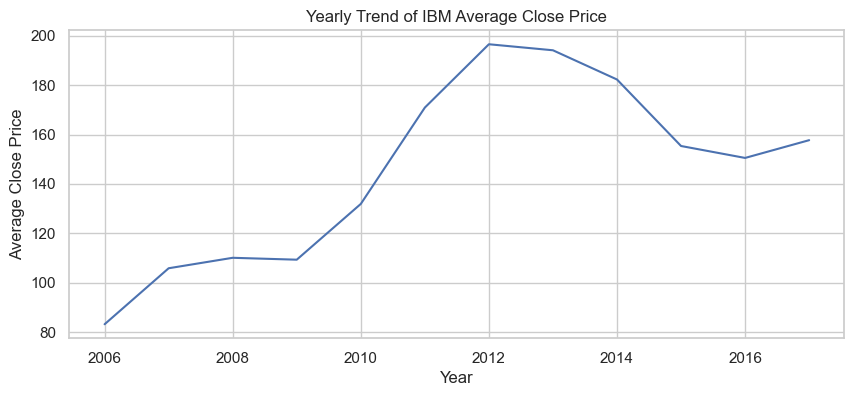

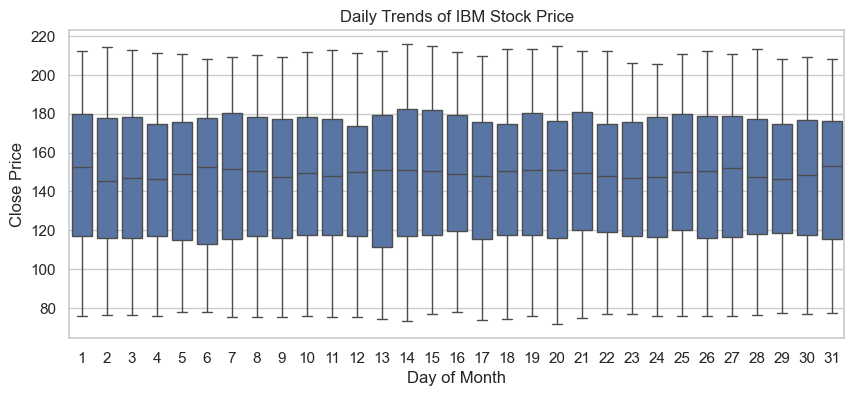

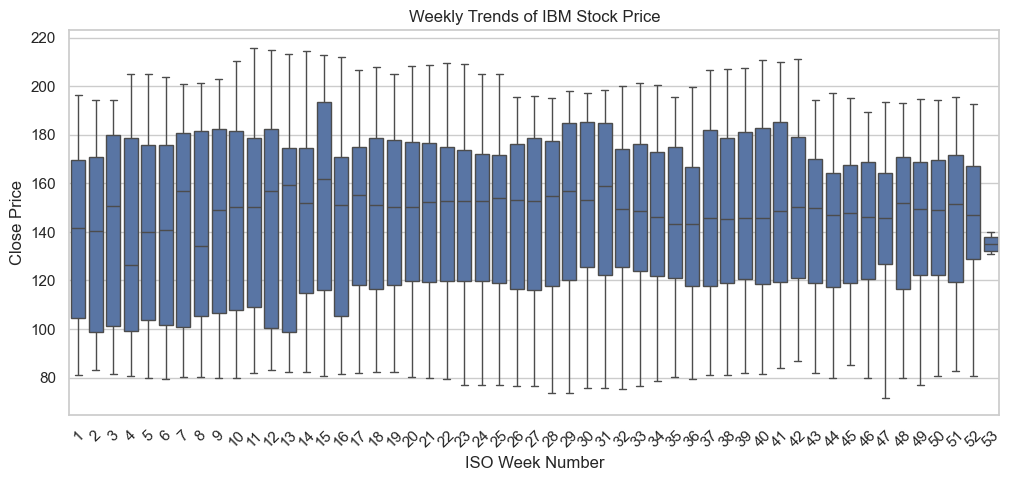

In [76]:
# Checking for patterns in different sequence lengths

# Set plot style
sns.set(style='whitegrid')

# 1. Monthly trends
plt.figure(figsize=(10, 4))
sns.boxplot(x='Month', y='IBM_Close', data=merged_df)
plt.title('Monthly Trends of IBM Stock Price')
plt.xlabel('Month')
plt.ylabel('Close Price')
plt.show()

# 2. Quarterly trends
plt.figure(figsize=(8, 4))
sns.boxplot(x='Quarter', y='IBM_Close', data=merged_df)
plt.title('Quarterly Trends of IBM Stock Price')
plt.xlabel('Quarter')
plt.ylabel('Close Price')
plt.show()

# 3. Yearly Trend
plt.figure(figsize=(10, 4))
sns.lineplot(x='Year', y='IBM_Close', data=merged_df.groupby('Year')['IBM_Close'].mean().reset_index())
plt.title('Yearly Trend of IBM Average Close Price')
plt.xlabel('Year')
plt.ylabel('Average Close Price')
plt.show()

# 4. Daily 
plt.figure(figsize=(10, 4))
sns.boxplot(x='Day', y='IBM_Close', data=merged_df)
plt.title('Daily Trends of IBM Stock Price')
plt.xlabel('Day of Month')
plt.ylabel('Close Price')
plt.show()

#weekly trends
plt.figure(figsize=(12, 5))
sns.boxplot(x='Week', y='IBM_Close', data=merged_df)
plt.title('Weekly Trends of IBM Stock Price')
plt.xlabel('ISO Week Number')
plt.ylabel('Close Price')
plt.xticks(rotation=45)
plt.show()

- Our chosen target variable is **IBM_Close**
- We can see seasonality in Quaterly, Monthly and Yearly trends of the stock price
- Not chosing Year as a window because the window size will be huge in that scenario.
- Since the data is having long term data and company's are ussually evaluated QoQ so, we will go with a window size for Quarters
- Chosing **60** as window size


In [79]:
merged_df=merged_df.drop(columns=['Date','Year','Month','Day','Quarter','Week'])
merged_df.shape

(3018, 20)

- Dropped Date feature and other features like Year,Month,Week,Day and Quarter as we don't need them for RNN models and data input data will be sequentially fed to the network

#### **1.3.5** <font color =red> [2 marks] </font>
Call the functions to create testing and training instances of predictor and target features.

In [83]:
# Create data instances from the master data frame using decided window size and window stride
target=['IBM_Close']
window=60
stride=1
split_size=0.8
X_train,y_train,X_test,y_test,X_scaler,y_scaler=master(df1=merged_df,target_master=target,window_size_master=window,stride_master=stride,split=split_size)


In [85]:
# Check the number of data points generated
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape:  {X_test.shape}")
print(f"y_test shape:  {y_test.shape}")

X_train shape: (2366, 60, 20)
y_train shape: (2366, 1)
X_test shape:  (592, 60, 20)
y_test shape:  (592, 1)


**Check if the training and testing datasets are in the proper format to feed into neural networks.**

In [88]:
# Check if the datasets are compatible inputs to neural networks
print(f"X_train ndim: {X_train.ndim}")
print(f"y_train ndim: {y_train.ndim}") 
print(f"X_test ndim: {X_test.ndim}")
print(f"y_test ndim: {y_test.ndim}") 

print(f"Timesteps per window: {X_train.shape[1]}")
print(f"Number of features: {X_train.shape[2]}")

# Checking data type
print(f"X_train dtype: {X_train.dtype}")
print(f"y_train dtype: {y_train.dtype}")
print(f"X_test dtype: {X_test.dtype}")
print(f"y_test dtype: {y_test.dtype}")

X_train ndim: 3
y_train ndim: 2
X_test ndim: 3
y_test ndim: 2
Timesteps per window: 60
Number of features: 20
X_train dtype: float64
y_train dtype: float64
X_test dtype: float64
y_test dtype: float64


- The dimenssions of both training and test data after split is fine which is as follows:
    - X_train ndim: 3
    - y_train ndim: 2
    - X_test ndim: 3
    - y_test ndim: 2
- Datatype and sequence parameters are as follows:
    - Timesteps per window: 60
    - Number of features: 20
    - X_train dtype: float64
    - y_train dtype: float64
    - X_test dtype: float64
    - y_test dtype: float64


## **2 RNN Models** <font color =red> [20 marks] </font>

In this section, we will:
- Define a function that creates a simple RNN
- Tune the RNN for different hyperparameter values
- View the performance of the optimal model on the test data

### **2.1 Simple RNN Model** <font color =red> [10 marks] </font>

#### **2.1.1** <font color =red> [3 marks] </font>
Create a function that builds a simple RNN model based on the layer configuration provided.

In [25]:
# Create a function that creates a simple RNN model according to the model configuration arguments

def build_rnn_model(input_shape, neurons, dropout, learning_rate):
    model = Sequential()
    model.add(SimpleRNN(neurons, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(dropout))
    model.add(SimpleRNN(neurons, return_sequences=True))
    model.add(Dropout(dropout))
    model.add(SimpleRNN(neurons, return_sequences=True))
    model.add(Dropout(dropout))
    model.add(SimpleRNN(neurons))
    model.add(Dropout(dropout))
    model.add(Dense(1))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae','r2_score'])

    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, verbose=1)

    return model, [early_stop, reduce_lr]

#### **2.1.2** <font color =red> [4 marks] </font>
Perform hyperparameter tuning to find the optimal network configuration.

In [26]:
# Find an optimal configuration of simple RNN
param_grid = {
    'neurons': [32, 64],
    'dropout': [0.0, 0.25, 0.4],
    'learning_rate': [0.001, 0.0005],
    'batch_size': [32, 64]
    
}
del list
# Generate all combinations of hyperparameters
param_combinations = list(itertools.product(
    param_grid['neurons'],
    param_grid['dropout'],
    param_grid['learning_rate'],
    param_grid['batch_size'],
))

In [67]:
# Find the best configuration based on evaluation metrics

best_config = None
lowest_mae = float('inf')

for i, (neurons, dropout, lr, batch_size) in enumerate(param_combinations):
    print(f"\n Training config {i+1}/{len(param_combinations)}: neurons={neurons}, dropout={dropout}, lr={lr}, batch_size={batch_size}")

    model, callbacks = build_rnn_model(input_shape=(X_train.shape[1], X_train.shape[2]),
                                       neurons=neurons, dropout=dropout, learning_rate=lr)

    history = model.fit(X_train, y_train,
                        epochs=50,
                        batch_size=batch_size,
                        validation_data=(X_test, y_test),
                        callbacks=callbacks,
                        verbose=0)

    y_pred = model.predict(X_test)

    # Inverse transform predictions and true values
    y_pred_inv = y_scaler.inverse_transform(y_pred)
    y_test_inv = y_scaler.inverse_transform(y_test)

    mae = mean_absolute_error(y_test_inv, y_pred_inv)
    mse = mean_squared_error(y_test_inv, y_pred_inv)
    r2 = r2_score(y_test_inv, y_pred_inv)
    print(f" MAE: {mae:.4f}, MSE: {mse:.4f}, R2: {r2:.4f}")

    if mae < lowest_mae:
        lowest_mae = mae
        best_config = {
            'neurons': neurons,
            'dropout': dropout,
            'learning_rate': lr,
            'batch_size': batch_size,
            'mae': mae,
            'mse': mse,
            'r2_score': r2
        }

print("\n Best configuration found:")
for k, v in best_config.items():
    print(f"{k}: {v}")



 Training config 1/24: neurons=32, dropout=0.0, lr=0.001, batch_size=32

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step  
 MAE: 16.0356, MSE: 339.4990, R2: -1.1946

 Training config 2/24: neurons=32, dropout=0.0, lr=0.001, batch_size=64

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 19: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step  
 MAE: 10.6785, MSE: 156.2446, R2: -0.0100

 Training config 3/24: neurons=32, dropout=0.0, lr=0.0005, batch_size=32

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step  
 MAE: 4.5409, MSE: 40.9902, R2: 0.7350

 Training config 4/24: neurons=32, dropout=0.0, lr=0.0005, batch

Best configuration found for SimpleRNN Network:
- neurons: 64
- dropout: 0.0
- learning_rate: 0.0005
- batch_size: 32
- mae: 3.7222974772066686
- mse: 23.358520741364742
- r2_score: 0.8490037642192163

#### **2.1.3** <font color =red> [3 marks] </font>
Run for optimal Simple RNN Model and show final results.

In [68]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the model
model_final, callbacks_final = build_rnn_model(input_shape=(X_train.shape[1], X_train.shape[2]),
                                       neurons=64, dropout=0.0, learning_rate=0.0005)


In [69]:
#Training the model
history = model_final.fit(X_train, y_train,epochs=50,batch_size=32,validation_data=(X_test, y_test),callbacks=callbacks,verbose=1)

Epoch 1/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - loss: 0.0877 - mae: 0.2265 - r2_score: -0.1378 - val_loss: 0.0308 - val_mae: 0.1644 - val_r2_score: -3.1254 - learning_rate: 5.0000e-04
Epoch 2/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0284 - mae: 0.1277 - r2_score: 0.6453 - val_loss: 0.0034 - val_mae: 0.0453 - val_r2_score: 0.5379 - learning_rate: 5.0000e-04
Epoch 3/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0321 - mae: 0.1368 - r2_score: 0.6037 - val_loss: 0.0110 - val_mae: 0.0900 - val_r2_score: -0.4772 - learning_rate: 5.0000e-04
Epoch 4/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0200 - mae: 0.1068 - r2_score: 0.7372 - val_loss: 0.0118 - val_mae: 0.0958 - val_r2_score: -0.5766 - learning_rate: 5.0000e-04
Epoch 5/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0133 - mae: 0.0822 - r2_score: 0.8328 - val_loss: 0.0017 - val_mae: 0.0333 - val_r2_score: 0.7760 - learning_rate: 5.0000e-04
Epoch 6/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.

Plotting the actual vs predicted values

In [70]:
# Predict on the test data and plot
y_pred = model_final.predict(X_test)
y_pred_inv_srnn = y_scaler.inverse_transform(y_pred)
y_test_inv_srnn = y_scaler.inverse_transform(y_test)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step 


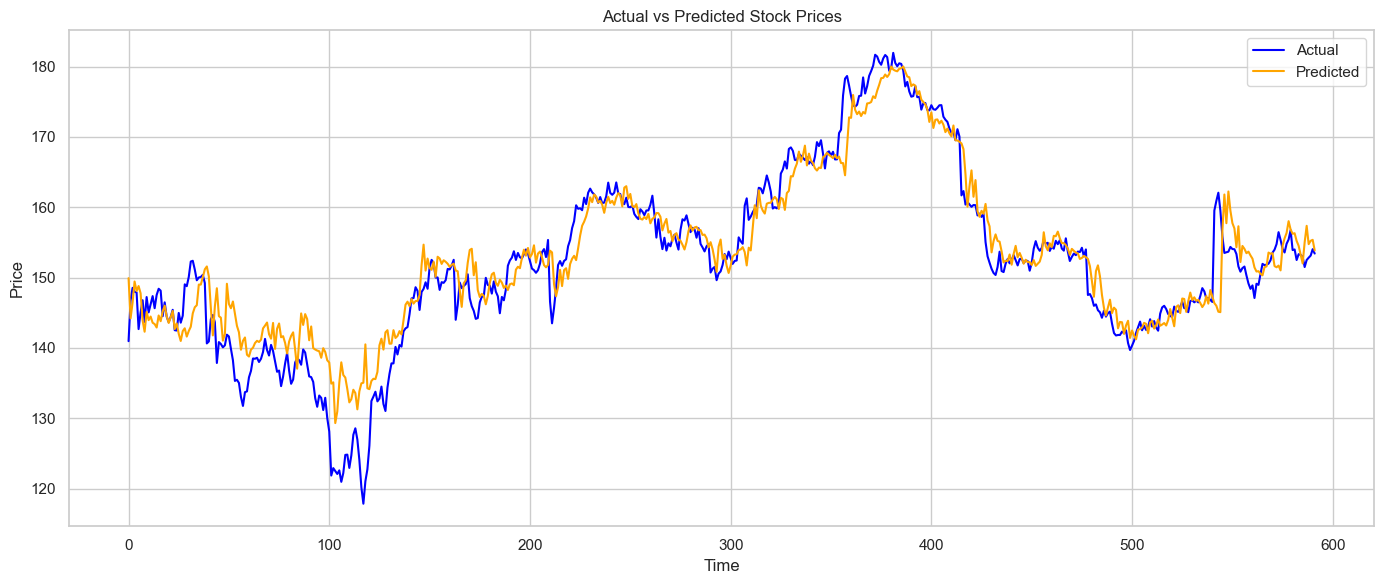

In [71]:
plt.figure(figsize=(14, 6))
plt.plot(y_test_inv_srnn, label='Actual', color='blue')
plt.plot(y_pred_inv_srnn, label='Predicted', color='orange')
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

It is worth noting that every training session for a neural network is unique. So, the results may vary slightly each time you retrain the model.

In [72]:
# Compute the performance of the model on the testing data set
mae_srnn = mean_absolute_error(y_test_inv_srnn, y_pred_inv_srnn)
mse_srnn = mean_squared_error(y_test_inv_srnn, y_pred_inv_srnn)
r2_srnn = r2_score(y_test_inv_srnn, y_pred_inv_srnn)
print(f"mea: {mae_srnn}")
print(f"mse: {mse_srnn}")
print(f"r2_score: {r2_srnn}")

mea: 2.8997889472342817
mse: 17.49840672319703
r2_score: 0.8868852365858534


Best Model's performance:
- mea: 2.8997889472342817
- mse: 17.49840672319703
- r2_score: 0.8868852365858534

Simple RNN Model's Summary:
- Best configuration found for SimpleRNN Network:
    - neurons: 64
    - dropout: 0.0
    - learning_rate: 0.0005
    - batch_size: 32
    - mae: 3.7222974772066686
    - mse: 23.358520741364742
    - r2_score: 0.8490037642192163
- Best Model's performance on test data:
    - mea: 2.8997889472342817
    - mse: 17.49840672319703
    - r2_score: 0.8868852365858534
- Model has done a pretty good job in predicting the price of IBM_Close as can be seen in the visualizations as well.

### **2.2 Advanced RNN Models** <font color =red> [10 marks] </font>

In this section, we will:
- Create an LSTM or a GRU network
- Tune the network for different hyperparameter values
- View the performance of the optimal model on the test data

#### **2.2.1** <font color =red> [3 marks] </font>
Create a function that builds an advanced RNN model with tunable hyperparameters.

In [27]:
# Define a function to create a model and specify default values for hyperparameters
def build_lstm_model(input_shape, neurons, dropout, learning_rate):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(dropout))
    model.add(LSTM(neurons, return_sequences=True))
    model.add(Dropout(dropout))
    model.add(LSTM(neurons, return_sequences=True))
    model.add(Dropout(dropout))    
    model.add(LSTM(neurons))
    model.add(Dense(1))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, verbose=1)

    return model, [early_stop, reduce_lr]


#### **2.2.2** <font color =red> [4 marks] </font>
Perform hyperparameter tuning to find the optimal network configuration.

In [28]:
# Find an optimal configuration
best_config_lstm = None
lowest_mae_lstm = float('inf')

for i, (neurons, dropout, lr, batch_size) in enumerate(param_combinations):
    print(f"\n Training config {i+1}/{len(param_combinations)}: neurons={neurons}, dropout={dropout}, lr={lr}, batch_size={batch_size}")

    model, callbacks = build_lstm_model(input_shape=(X_train.shape[1], X_train.shape[2]),
                                        neurons=neurons, dropout=dropout, learning_rate=lr)

    history_lstm = model.fit(X_train, y_train,
                        epochs=50,
                        batch_size=batch_size,
                        validation_data=(X_test, y_test),
                        callbacks=callbacks,
                        verbose=0)

    y_pred = model.predict(X_test)

    # Inverse transform predictions and true values
    y_pred_inv = y_scaler.inverse_transform(y_pred)
    y_test_inv = y_scaler.inverse_transform(y_test)

    mae = mean_absolute_error(y_test_inv, y_pred_inv)
    mse = mean_squared_error(y_test_inv, y_pred_inv)
    r2 = r2_score(y_test_inv, y_pred_inv)
    print(f" MAE: {mae:.4f}, MSE: {mse:.4f}, R2: {r2:.4f}")

    if mae < lowest_mae_lstm:
        lowest_mae_lstm = mae
        best_config_lstm = {
            'neurons': neurons,
            'dropout': dropout,
            'learning_rate': lr,
            'batch_size': batch_size,
            'mae': mae,
            'mse': mse,
            'r2_score': r2
        }

print("\n Best LSTM configuration found:")
for k, v in best_config_lstm.items():
    print(f"{k}: {v}")



 Training config 1/24: neurons=32, dropout=0.0, lr=0.001, batch_size=32

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 19: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step 
 MAE: 4.5873, MSE: 32.9361, R2: 0.7871

 Training config 2/24: neurons=32, dropout=0.0, lr=0.001, batch_size=64

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step 
 MAE: 5.6439, MSE: 49.7335, R2: 0.6785

 Training config 3/24: neurons=32, dropout=0.0, lr=0.0005, batch_size=32

Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 18: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step 
 MAE: 5.4282, MSE: 45.3220, R2: 0.7

Best LSTM configuration found:
- neurons: 64
- dropout: 0.25
- learning_rate: 0.001
- batch_size: 32
- mae: 4.218023196555473
- mse: 30.479674729292583
- r2_score: 0.802970564664406

#### **2.2.3** <font color =red> [3 marks] </font>
Run for optimal RNN Model and show final results.

In [29]:
# Create the model with a combination of potentially optimal hyperparameter values and retrain the model
model_lstm, callbacks_lstm = build_lstm_model(input_shape=(X_train.shape[1], X_train.shape[2]),
                                       neurons=64, dropout=0.25, learning_rate=0.001)
history_lstm = model_lstm.fit(X_train, y_train,epochs=50,batch_size=32,validation_data=(X_test, y_test),callbacks=callbacks,verbose=1)

Epoch 1/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - loss: 0.0706 - mae: 0.2130 - val_loss: 0.0188 - val_mae: 0.1167 - learning_rate: 0.0010
Epoch 2/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0211 - mae: 0.1071 - val_loss: 0.0316 - val_mae: 0.1691 - learning_rate: 0.0010
Epoch 3/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0126 - mae: 0.0827 - val_loss: 0.0126 - val_mae: 0.1009 - learning_rate: 0.0010
Epoch 4/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.0097 - mae: 0.0724 - val_loss: 0.0158 - val_mae: 0.1153 - learning_rate: 0.0010
Epoch 5/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.0073 - mae: 0.0624 - val_loss: 0.0057 - val_mae: 0.0639 - learning_rate: 0.0010
Epoch 6/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0092 - mae: 0.0676 - val_loss: 0.0279 - val_mae: 0.1587 - learning_rate: 0.0010
Epoch 7/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0141 - mae: 0.0882 - val_loss: 0.0075 - val_mae: 0.0738 - learning_rate: 0.0010
Epoch 8/50
73

In [30]:
#Making predictions:
y_pred = model_lstm.predict(X_test)
y_pred_inv_lstm = y_scaler.inverse_transform(y_pred)
y_test_inv_lstm = y_scaler.inverse_transform(y_test)

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step 


In [31]:
# Compute the performance of the model on the testing data set
mae_lstm = mean_absolute_error(y_test_inv_lstm, y_pred_inv_lstm)
mse_lstm = mean_squared_error(y_test_inv_lstm, y_pred_inv_lstm)
r2_lstm = r2_score(y_test_inv_lstm, y_pred_inv_lstm)
print(f"mea: {mae_lstm}")
print(f"mse: {mse_lstm}")
print(f"r2_score: {r2_lstm}")

mea: 5.125363513843434
mse: 40.30305179978473
r2_score: 0.7394694133405182


Best LSTM Model's Performance:
- mea: 5.125363513843434
- mse: 40.30305179978473
- r2_score: 0.7394694133405182

Plotting the actual vs predicted values

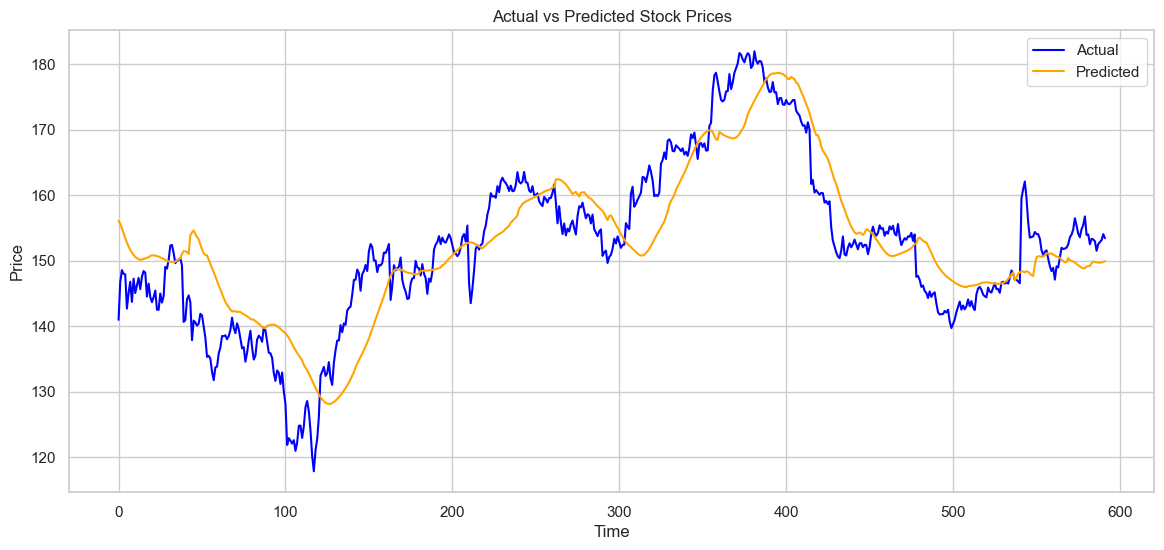

In [34]:
# Predict on the test data
plt.figure(figsize=(14, 6))
plt.plot(y_test_inv_lstm, label='Actual', color='blue')
plt.plot(y_pred_inv_lstm, label='Predicted', color='orange')
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

LSTM Model's Summary:
- Best LSTM configuration:
    - neurons: 64
    - dropout: 0.25
    - learning_rate: 0.001
    - batch_size: 32
    - mae: 4.218023196555473
    - mse: 30.479674729292583
    - r2_score: 0.802970564664406
- Best LSTM Model's Performance:
    - mea: 5.125363513843434
    - mse: 40.30305179978473
    - r2_score: 0.7394694133405182
- We have kept the window size, stride size and other parameters same as simple RNN model
- We were expecting improvement from SimpleRNN model when using LSTM
- Although we did observed that LSTM was performing better than RNN model in some of the iterations bu when we ran the code for one final time the RNN's performance was better than LSTM.

## **3 Predicting Multiple Target Variables** <font color =red> [OPTIONAL] </font>

In this section, we will use recurrent neural networks to predict stock prices for more than one company.

### **3.1 Data Preparation**

#### **3.1.1**
Create testing and training instances for multiple target features.

You can take the closing price of all four companies to predict here.

In [59]:
# Create data instances from the master data frame using a window size of 65, a window stride of 5 and a test size of 20%
# Specify the list of stock names whose 'Close' values you wish to predict using the 'target_names' parameter



- Chosing 'AMZN_Close', 'GOOGL_Close', 'IBM_Close', 'MSFT_Close' as target variables

In [36]:
#Defining function to create windows

In [37]:
#Defining function for windowed sclaing


In [38]:
#Defining master function


In [39]:
# Generating the test and validation data by calling master function


In [58]:
# Check the number of data points generated


### **3.2 Run RNN Models**

#### **3.2.1**
Perform hyperparameter tuning to find the optimal network configuration for Simple RNN model.

In [60]:
# Find an optimal configuration of simple RNN


In [61]:
# Find an optimal configuration of simple RNN



In [62]:
# Find the best configuration


In [63]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the
# Create a model with a combination of potentially optimal hyperparameter values and retrain the model


In [64]:
# Compute the performance of the model on the testing data set



In [65]:
# Plotting the actual vs predicted values for all targets




#### **3.2.2**
Perform hyperparameter tuning to find the optimal network configuration for Advanced RNN model.

In [66]:
# Find an optimal configuration of advanced RNN



In [67]:
# Find the best configuration


In [68]:
# Create a model with a combination of potentially optimal hyperparameter values and retrain the model


In [69]:
# Compute the performance of the model on the testing data set


In [70]:
# Compute the performance of the model on the testing data set


In [71]:
# Plotting the actual vs predicted values for all targets



## **4 Conclusion** <font color =red> [5 marks] </font>

### **4.1 Conclusion and insights** <font color =red> [5 marks] </font>

#### **4.1.1** <font color =red> [5 marks] </font>
Conclude with the insights drawn and final outcomes and results.

We will divide Conclussion in 2 parts, Dataset Processing and Models

#### **Dataset Processing:**
- We created a function to horizontally merge all the dataset, we have appended company's name for each feature and dropped Name column.
- Handled **2 missing values** by dropping them
- **EDA:**
    - Stock Volume has decreased over the years. that's ussually a indicator of rise in the stock price.
    - Google's volume has significantly decreased over the years
    - IBM stock volume is stable after 2012
- **Window selection:**
    - Our chosen target variable is **IBM_Close**
    - We can see seasonality in Quaterly, Monthly and Yearly trends of the stock price
    - Not chosing Year as a window because the window size will be huge in that scenario.
    - Since the data is having long term data and company's are ussually evaluated QoQ so, we will go with a window size for Quarters
    - Chosing **60** as window size
- **Training and Validation Data:**
    - X_train shape: (2366, 60, 20)
    - y_train shape: (2366, 1)
    - X_test shape:  (592, 60, 20)
    - y_test shape:  (592, 1)
    - X_train ndim: 3
    - y_train ndim: 2
    - X_test ndim: 3
    - y_test ndim: 2
    - Timesteps per window: 60
    - Number of features: 20
    - X_train dtype: float64
    - y_train dtype: float64
    - X_test dtype: float64
    - y_test dtype: float64

#### **RNN Models:**
- Models Used:
    - **SimpleRNN**
    - **LSTM model**
- RNN layers used: **4**
- Window Size: **60**
- Stride Size: **1**
- **Metrics used include:**
    - Mean Absolute Error (MAE)
    - Mean Squared Error (MSE)
    - R² score
- **Regularizations used:**
    - Dropouts
    - learning_rate
    - ReduceLROnPlateau
    - EarlyStopping

- **Simple RNN Model's Summary:**
    - **Best configuration found for SimpleRNN Network:**
      - neurons: **64**
      - dropout: **0.0**
      - learning_rate: **0.0005**
      - batch_size: **32**
      - mae: **3.7222974772066686**
      - mse: **23.358520741364742**
      - r2_score: **0.8490037642192163**
    - **Best Model's performance on test data:**
      - mea: **2.8997889472342817**
      - mse: **17.49840672319703**
      - r2_score: **0.8868852365858534**
    - Model has done a pretty good job in predicting the price of IBM_Close as can be seen in the visualizations as well.
    - The predicted vs actual plot shows that the predicted values are following the trend as per the actual values and it was able to learn small changes as well as can be seen in the graph that predicted curve is mimiking the actual curve.
- **LSTM Model's Summary:**
    - **Best LSTM configuration**:
        - neurons: **64**
        - dropout: **0.25**
        - learning_rate: **0.001**
        - batch_size: **32**
        - mae: **4.218023196555473**
        - mse: **30.479674729292583**
        - r2_score: **0.802970564664406**
    - **Best LSTM Model's Performance on test data:**
        - mea: **5.125363513843434**
        - mse: **40.30305179978473**
        - r2_score: **0.7394694133405182**
    - We have kept the window size, stride size and other parameters same as simple RNN model
    - We were expecting improvement from SimpleRNN model when using LSTM
    - Although we did observed that LSTM was performing better than RNN model in some of the iterations bu when we ran the code for one final time the RNN's performance was better than LSTM.
    - The predicted vs actual plot shows that the predicted values are following the trend as per the actual values on high-level although the model was not able to learn the small patterns

- RNN-based models are well-suited for sequential stock price data, and incorporating data from multiple similar companies helped in capturing broader market trends.
- Hyperparameter tuning and proper regularization (e.g., dropout) significantly improved model accuracy.
- While the model shows promising results, further enhancements like multivariate inputs (e.g., Volume, High/Low prices) or attention mechanisms could yield even better predictions.